## Imports, Directories, and Devices

In [1]:
import os
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import tensorflow as tf
import pathlib

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam

In [2]:
data_set_path = "C:\\Users\\Mindicree\\Documents\\College Stuff\\2021 Spring\\Computer Vision\\data-set-convert-2"
keras_path = "C:\\Users\\Mindicree\\Documents\\College Stuff\\2021 Spring\\Computer Vision\\Keras Models"
tflite_path = "C:\\Users\\Mindicree\\Documents\\College Stuff\\2021 Spring\\Computer Vision\\TFLite Models"
os.chdir(data_set_path)
data_dir = pathlib.Path(data_set_path)

In [3]:
device_name = tf.test.gpu_device_name()
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
print(tf.config.list_physical_devices())
print('GPU: ' + device_name)

Num GPUs Available:  1
[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
GPU: /device:GPU:0


## Tuning Parameters

In [4]:
#Parameter Tuning
batch_size = 1           #16-64 seems best
epochs = 32               #32-64 seems best
learning_rate = 0.00015     #0.0001 - 0.001 seems best
patience_limit = 512       #set less than epochs size for early stopping
validation_split = 0.2    #percent for validation data. 0.2 seems best

img_height = 256          #128 or higher seems best
img_width = 256           #128 or higher seems best

conv_size_1 = 128          #original is 16
drop_size_1 = 0.2         #0.2-0.5 seems best
conv_size_2 = 64          #original is 32
drop_size_2 = 0.2         #0.2-0.5 seems best
conv_size_3 = 32          #original is 64
drop_size_3 = 0.2         #0.2-0.5 seems best
output_size = 256         #original is 128

<h1>Getting Data From Directory and Splitting</h1>

In [5]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=validation_split,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=validation_split,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 1500 files belonging to 15 classes.
Using 1200 files for training.
Found 1500 files belonging to 15 classes.
Using 300 files for validation.


In [6]:
print(train_ds.class_names)

['bluejay', 'cardinal', 'crow', 'dove', 'eagle', 'falcon', 'flamingo', 'hummingbird', 'magpie', 'ostrich', 'owl', 'parrot', 'robin', 'turkey', 'woodpecker']


In [7]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

## Creating The Model

In [8]:
num_classes = 15

data_augmentation = keras.Sequential(
  [
    layers.experimental.preprocessing.RandomFlip("horizontal", 
                                                 input_shape=(img_height, 
                                                              img_width,
                                                              3)),
    layers.experimental.preprocessing.RandomRotation(0.1),
    layers.experimental.preprocessing.RandomZoom(0.1),
  ]
)

model = Sequential([
  data_augmentation,
  layers.experimental.preprocessing.Rescaling(1./255),
  layers.Conv2D(conv_size_1, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(drop_size_1),
  layers.Conv2D(conv_size_2, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(drop_size_2),
  layers.Conv2D(conv_size_3, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(drop_size_3),
  layers.Flatten(),
  layers.Dense(25, activation='relu'),
  layers.Dense(num_classes, activation='sigmoid')
])

lr_callback = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3, min_lr=0.000001, verbose=1)
es_callback = keras.callbacks.EarlyStopping(monitor='val_loss', patience=patience_limit)

In [9]:
model.compile(optimizer=Adam(lr=learning_rate),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential (Sequential)      (None, 256, 256, 3)       0         
_________________________________________________________________
rescaling (Rescaling)        (None, 256, 256, 3)       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 256, 256, 128)     3584      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 128, 128, 128)     0         
_________________________________________________________________
dropout (Dropout)            (None, 128, 128, 128)     0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 128, 128, 64)      73792     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 64, 64, 64)       

## Training The Model

In [10]:
try:
  with tf.device(device_name):
    print("Using GPU: " + device_name)
    history = model.fit(
      train_ds,
      validation_data=val_ds,
      epochs=epochs,
      callbacks=[es_callback, lr_callback]
    )
except Exception as e:
  print(e)
  print("Using CPU")
  history = model.fit(
      train_ds,
      validation_data=val_ds,
      epochs=epochs,
      callbacks=[es_callback]
    )

Using GPU: /device:GPU:0
Epoch 1/32
1200/1200 [==============================] - 49s 20ms/step - loss: 2.7300 - accuracy: 0.0658 - val_loss: 2.7085 - val_accuracy: 0.0567
Epoch 2/32
1200/1200 [==============================] - 11s 10ms/step - loss: 2.7079 - accuracy: 0.0809 - val_loss: 2.7090 - val_accuracy: 0.0500
Epoch 3/32
1200/1200 [==============================] - 12s 10ms/step - loss: 2.7133 - accuracy: 0.0561 - val_loss: 2.7055 - val_accuracy: 0.1167
Epoch 4/32
1200/1200 [==============================] - 12s 10ms/step - loss: 2.6316 - accuracy: 0.1155 - val_loss: 2.4501 - val_accuracy: 0.2267
Epoch 5/32
1200/1200 [==============================] - 12s 10ms/step - loss: 2.4119 - accuracy: 0.2111 - val_loss: 2.3303 - val_accuracy: 0.2433
Epoch 6/32
1200/1200 [==============================] - 12s 10ms/step - loss: 2.2554 - accuracy: 0.2612 - val_loss: 2.0400 - val_accuracy: 0.3433
Epoch 7/32
1200/1200 [==============================] - 11s 10ms/step - loss: 1.9162 - accuracy: 0.

## Result Visualization

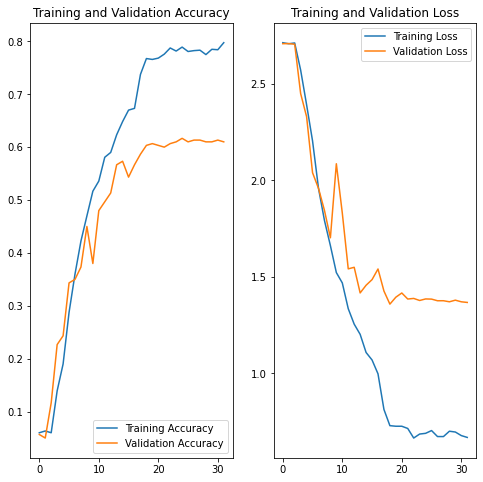

In [11]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

## Model Export

In [12]:
def average(some_list):
  return round(sum(some_list)/len(some_list), 4)

def median(some_list):
  return round(some_list[int(len(some_list)/2)], 4)

def parameters_to_string():
  return 'bs' + str(batch_size) + '--ep'+ str(epochs) + '--lr'+ str(learning_rate) + '--pl'+ str(patience_limit) + '--vs'+ str(validation_split) + '--dim'+ str(img_height) + 'x'+ str(img_width) + '--cv1'+ str(conv_size_1) + '--dr1'+ str(drop_size_1) + '--cv2'+ str(conv_size_2) + '--dr2'+ str(drop_size_2) + '--cv3'+ str(conv_size_3) + '--dr3'+ str(drop_size_3) + '--out'+ str(output_size)+''


#Save keras model
os.chdir(keras_path)
file_string = 'avg' + str(average(val_acc)) + '--med' + str(median(val_acc)) + '--max' + str(round(max(val_acc), 4)) + '--param' + parameters_to_string() + ''
model.save(file_string)

#Convert model to tflite model
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

# Save tflite model.
os.chdir(tflite_path)
file_string = 'avg' + str(average(val_acc)) + '--med' + str(median(val_acc)) + '--max' + str(round(max(val_acc), 4)) + '--param' + parameters_to_string() + '.tflite'
with open(file_string, 'wb') as f:
  f.write(tflite_model)

INFO:tensorflow:Assets written to: avg0.4826--med0.5667--max0.6167--parambs1--ep32--lr0.00015--pl512--vs0.2--dim256x256--cv1128--dr10.2--cv264--dr20.2--cv332--dr30.2--out256\assets
INFO:tensorflow:Assets written to: C:\Users\MINDIC~1\AppData\Local\Temp\tmp8jugmxpi\assets


In [13]:
print(file_string)

avg0.4826--med0.5667--max0.6167--parambs1--ep32--lr0.00015--pl512--vs0.2--dim256x256--cv1128--dr10.2--cv264--dr20.2--cv332--dr30.2--out256.tflite
